In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import pickle

In [22]:
label_dict = pickle.load(open('../data/label_dict.pkl', 'rb'))

In [18]:
def load_fold(id):
    df = pd.read_csv(f'../data/orig/fold{id}.csv')
    X = df.drop(['label', 'audio'], axis=1).values
    y = df['label'].values
    return X, y

def train_base_learners(X_train, y_train):
    
    # train base learners, don't use tuned hyperparameter
    svm = SVC(probability=False, kernel='rbf', C=1.0, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose = -1)

    svm.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    lgbm.fit(X_train, y_train)

    return svm, rf, lgbm

def get_stack_features(svm, rf, lgbm, X):
    # base learners predict
    svm_pred = svm.predict(X)  # (N,)
    rf_proba = rf.predict_proba(X)  # (N, C)
    lgbm_proba = lgbm.predict_proba(X)  # (N, C)

    # SVM: one-hot encoding
    num_classes = rf_proba.shape[1]
    svm_onehot = np.eye(num_classes)[svm_pred]

    # stacking features
    stacked_features = np.hstack([svm_onehot, rf_proba, lgbm_proba])  # (N, 3*C)
    return stacked_features

In [19]:
def stacking_10fold():
    all_meta_X = []
    all_meta_y = []
    fold_stack_features = {}
    fold_labels = {}

    # 先用 10 fold 做 base learners out-of-fold 預測產生 stacking features
    for val_fold in range(10):
        # 訓練資料：除了 val_fold 以外的 folds
        train_folds = [f for f in range(10) if f != val_fold]
        X_train_list, y_train_list = [], []
        for f in train_folds:
            Xf, yf = load_fold(f)
            X_train_list.append(Xf)
            y_train_list.append(yf)
        X_train = np.vstack(X_train_list)
        y_train = np.hstack(y_train_list)

        # 驗證資料
        X_val, y_val = load_fold(val_fold)

        # 訓練 base learners
        svm, rf, lgbm = train_base_learners(X_train, y_train)

        # 產生 stacking features for validation fold
        val_stack_feats = get_stack_features(svm, rf, lgbm, X_val)

        all_meta_X.append(val_stack_feats)
        all_meta_y.append(y_val)

        # 儲存 fold 預測結果和標籤
        fold_stack_features[val_fold] = val_stack_feats
        fold_labels[val_fold] = y_val

        print(f"Fold {val_fold} base learners trained and stacking features generated.")

    # 將所有 folds 的 stacking features 合併，作為 meta learner 訓練資料
    meta_X = np.vstack(all_meta_X)
    meta_y = np.hstack(all_meta_y)

    # 用 Logistic Regression 當 meta learner
    meta_clf = LogisticRegression(max_iter=1000, random_state=42)
    meta_clf.fit(meta_X, meta_y)
    print("Meta learner trained on out-of-fold stacking features.")

    # 最後做一次 10-fold CV，測試 meta learner 效果（用剛才的 stacking features）
    all_preds = []
    all_true = []
    for fold in range(10):
        X_test = fold_stack_features[fold]
        y_test = fold_labels[fold]

        y_pred = meta_clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"Fold {fold} Meta learner accuracy: {acc:.4f}")

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    print("\nOverall meta learner classification report:")
    print(classification_report(all_true, all_preds))
    
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Meta Learner Confusion Matrix (10-fold CV)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Fold 0 base learners trained and stacking features generated.
Fold 1 base learners trained and stacking features generated.
Fold 2 base learners trained and stacking features generated.
Fold 3 base learners trained and stacking features generated.
Fold 4 base learners trained and stacking features generated.
Fold 5 base learners trained and stacking features generated.
Fold 6 base learners trained and stacking features generated.
Fold 7 base learners trained and stacking features generated.
Fold 8 base learners trained and stacking features generated.
Fold 9 base learners trained and stacking features generated.
Meta learner trained on out-of-fold stacking features.
Fold 0 Meta learner accuracy: 0.6712
Fold 1 Meta learner accuracy: 0.6892
Fold 2 Meta learner accuracy: 0.5773
Fold 3 Meta learner accuracy: 0.6212
Fold 4 Meta learner accuracy: 0.6282
Fold 5 Meta learner accuracy: 0.6075
Fold 6 Meta learner accuracy: 0.6766
Fold 7 Meta learner accuracy: 0.6625
Fold 8 Meta learner accuracy:

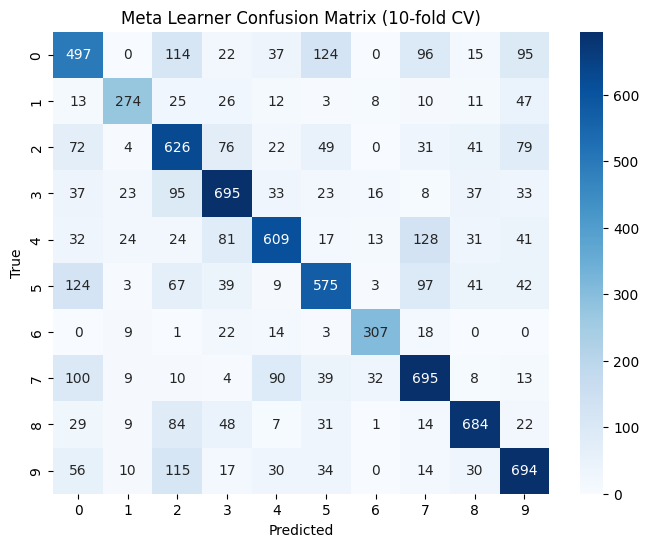

In [20]:
stacking_10fold()

In [21]:
performance = {
	'Presentation':     {'0': 0.29, '1': 0.42, '2': 0.51, '3': 0.59, '4': 0.61, 
                 		 '5': 0.51, '6': 0.69, '7': 0.55, '8': 0.54, '9': 0.55},
                          
	'Only LGBM':		{'0': 0.34, '1': 0.60, '2': 0.55, '3': 0.63, '4': 0.58, 
                 		 '5': 0.53, '6': 0.78, '7': 0.58, '8': 0.71, '9': 0.62},
						 
    'Stacking':      	{'0': 0.51, '1': 0.69, '2': 0.58, '3': 0.68, '4': 0.65, 
                 		 '5': 0.61, '6': 0.81, '7': 0.66, '8': 0.75, '9': 0.67},
}

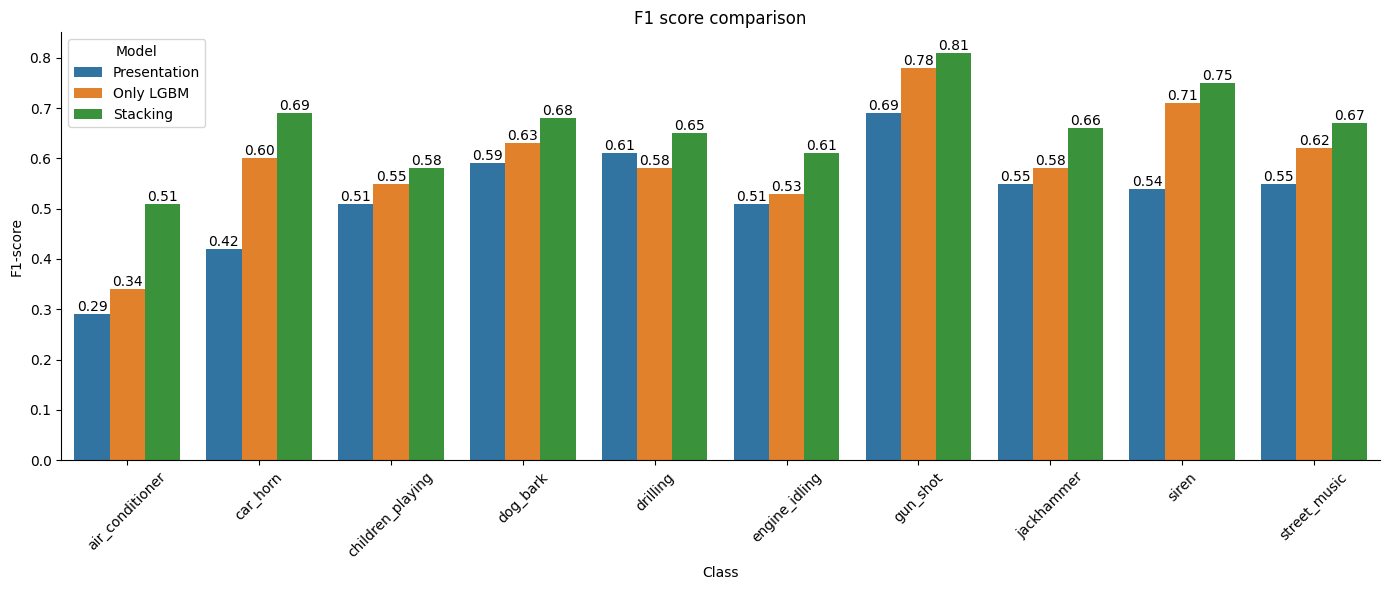

In [26]:
df = pd.DataFrame(performance).T  # 模型為 index，label 為 column
df = df.reset_index().melt(id_vars='index', var_name='Class', value_name='F1-score')
df.rename(columns={'index': 'Model'}, inplace=True)

# 對照 label 名稱（如果有 label_dict 的話）
df['Class'] = df['Class'].astype(int).map(label_dict)

# 繪圖
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df, x='Class', y='F1-score', hue='Model')
ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=10)
ax.bar_label(ax.containers[1], fmt='%.2f', fontsize=10)
ax.bar_label(ax.containers[2], fmt='%.2f', fontsize=10)
plt.xticks(rotation=45)
plt.title("F1 score comparison")
sns.despine()
plt.tight_layout()
plt.show()

In [27]:
performance = {
    'Presentation':     {'0': 0.29, '1': 0.42, '2': 0.51, '3': 0.59, '4': 0.61, 
                 		 '5': 0.51, '6': 0.69, '7': 0.55, '8': 0.54, '9': 0.55},
    'Logistic': 		{'0': 0.36, '1': 0.57, '2': 0.54, '3': 0.59, '4': 0.60, 
                 		 '5': 0.52, '6': 0.67, '7': 0.57, '8': 0.69, '9': 0.58},
    'KNN':      		{'0': 0.35, '1': 0.55, '2': 0.45, '3': 0.56, '4': 0.48, 
                 		 '5': 0.48, '6': 0.76, '7': 0.39, '8': 0.64, '9': 0.56},
    'SVM-RBF':  		{'0': 0.38, '1': 0.66, '2': 0.56, '3': 0.66, '4': 0.64, 
                 		 '5': 0.57, '6': 0.81, '7': 0.54, '8': 0.71, '9': 0.64},
    'RF':       		{'0': 0.38, '1': 0.59, '2': 0.53, '3': 0.62, '4': 0.57, 
                 		 '5': 0.56, '6': 0.77, '7': 0.59, '8': 0.71, '9': 0.60},
    'LGBM':     		{'0': 0.34, '1': 0.60, '2': 0.55, '3': 0.63, '4': 0.58, 
                 		 '5': 0.53, '6': 0.78, '7': 0.58, '8': 0.71, '9': 0.62},
    'XGB':      		{'0': 0.35, '1': 0.59, '2': 0.54, '3': 0.63, '4': 0.58, 
                 		 '5': 0.52, '6': 0.79, '7': 0.55, '8': 0.70, '9': 0.63},
	'Stacking':			{'0': 0.51, '1': 0.69, '2': 0.58, '3': 0.68, '4': 0.65, 
                 		 '5': 0.61, '6': 0.81, '7': 0.66, '8': 0.75, '9': 0.67},
}

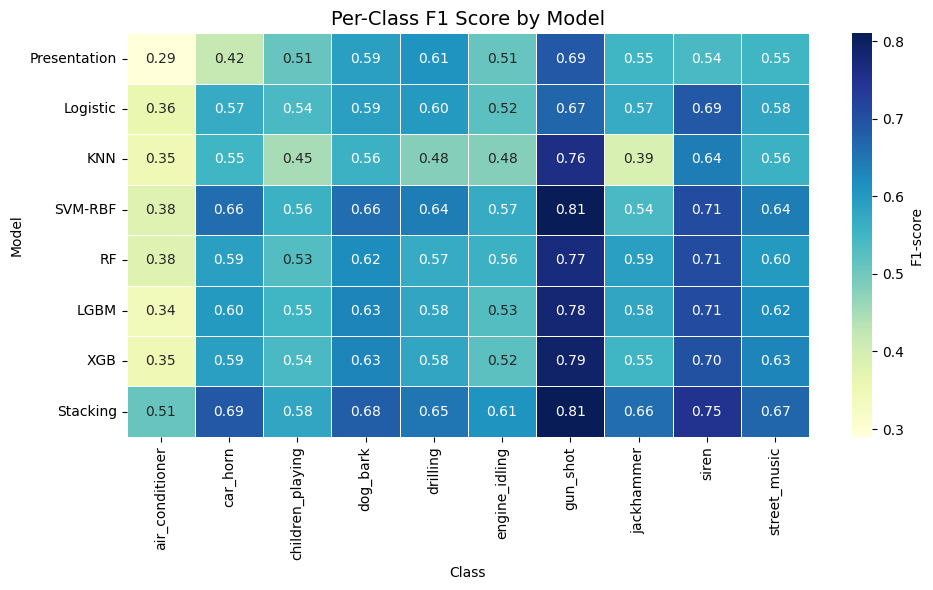

In [ ]:
# 建 DataFrame
df = pd.DataFrame(performance).T
df.columns = df.columns.astype(int).map(label_dict)
df.index.name = "Model"

# 畫圖
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'F1-score'})
plt.title("Per-Class F1 Score by Model", fontsize=14)
plt.ylabel("Model")
plt.xlabel("Class")
plt.tight_layout()
plt.show()